In [30]:
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import yfinance as yf
import itertools
import math
from co import *
import ndtest
import random
from hurst import *


# Ticker list and trade/model calibration dates

In [31]:
#sp500 ticker download
import bs4 as bs
import pickle
import requests

def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
        
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers

x=save_sp500_tickers()

for i in range (0,len(x)):
    x[i]=x[i].replace('\n', '')
x.remove('BRK.B')
x.remove('BF.B')
x.remove('ZTS')
x.remove('ZION')
x.remove('ZBH')
x.remove('ZBRA')
x.remove('ALB')
asset_list=x

In [32]:
#Asset list
lst=asset_list

#dates for model calibration
start_data='2020-08-19'
end_data='2022-08-19'

#dates for trading with algo
start_trade='2022-08-01'
end_trade='2022-09-01'

index_comp='SPY'

# Length of trading period
from datetime import *

d1=datetime.strptime(start_trade, "%Y-%m-%d")
d2=datetime.strptime(end_trade, "%Y-%m-%d")
length_trade_period =(np.abs(d1-d2)).days


# Mean return and volatility for each asset in basket (calculated using VWAP)

In [ ]:
#feature vectors for each asset
mean_ret_lst=[]
vol_lst=[]

feature_df = pd.DataFrame(columns=['mean return', 'volatility'])

for i in lst:
    x=yf.download(i, start=start_trade, end=end_trade, interval = "1d")
    x.ta.vwap(append=True).dropna()
    x['Log_Returns'] = np.log(x['VWAP_D']) - np.log(x['VWAP_D'].shift(1))
    x = x['Log_Returns'].fillna(0)

    # mean return of trading period
    mean_ret = x.mean()*length_trade_period
    mean_ret_lst.append

    #mean volatility (vwap) of trading period
    vol=x.std()*np.sqrt(length_trade_period)
    
    feature_df.loc[i]= [mean_ret, vol]


# Mean returns and volatility of basket of assets

In [33]:
feature_df

,mean return,volatility,labels
MMM,-0.183411,0.106008,1
AOS,-0.114167,0.081251,1
ABT,-0.077187,0.054397,1
ABBV,-0.057189,0.040779,0
ABMD,-0.149033,0.107534,1
...,...,...,...
GWW,0.023936,0.052480,0
WYNN,-0.045989,0.120341,1
XEL,0.027682,0.037318,0
XYL,0.003984,0.102714,0


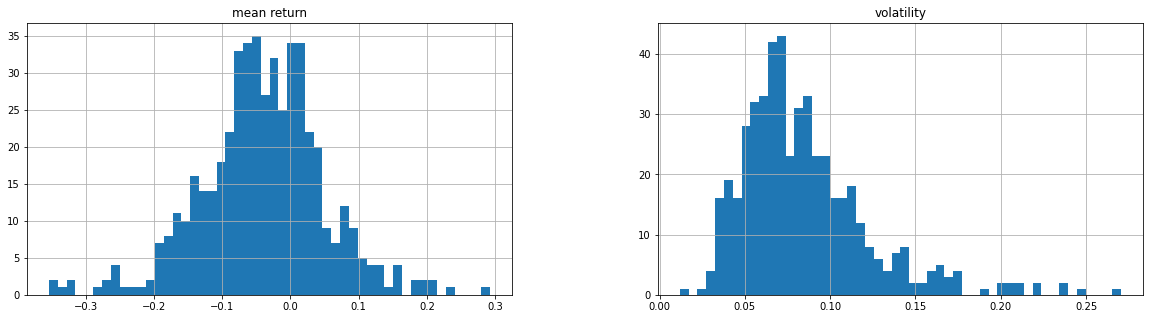

In [34]:
%matplotlib inline
feature_df.hist(bins=50, figsize=(20,5))
plt.show()

# As expected, returns are not perfectly Gaussian (some fat tails and not N(0,1)) so lets standardise data before running clustering algo

In [7]:
from sklearn.preprocessing import StandardScaler
feature_array=feature_df.values

scale=StandardScaler().fit(feature_array)

scale_feature_df=pd.DataFrame(scale.fit_transform(feature_array),
                              columns=feature_df.columns,
                              index=feature_df.index)
scale_feature_df


,mean return,volatility
MMM,-1.591385,0.557073
AOS,-0.820789,-0.094304
ABT,-0.409240,-0.800870
ABBV,-0.186687,-1.159185
ABMD,-1.208801,0.597228
...,...,...
GWW,0.716145,-0.851321
WYNN,-0.062044,0.934193
XEL,0.757837,-1.250249
XYL,0.494102,0.470399


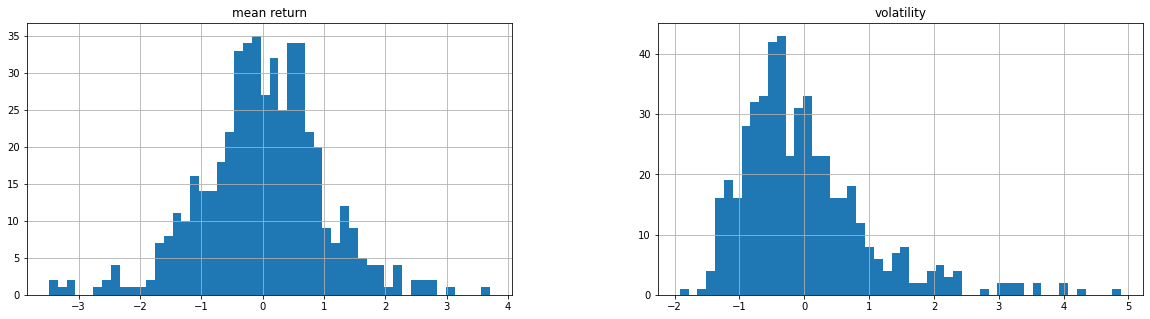

In [8]:
%matplotlib inline

scale_feature_df.hist(bins=50, figsize=(20,5))
plt.show()


# Optimal number of clusters

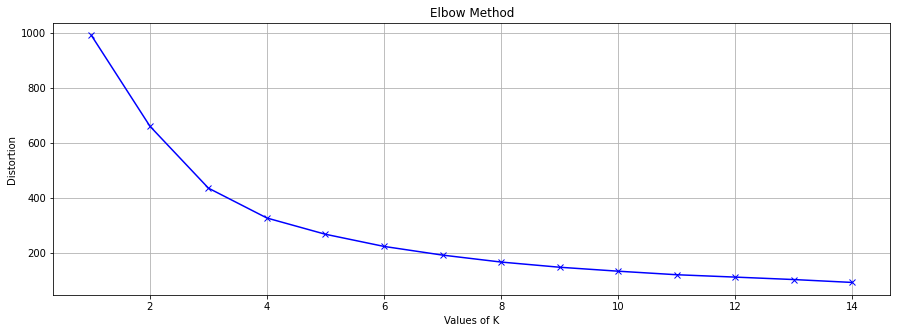

In [9]:
#find ideal numbers of clusters for our basket

from sklearn import metrics
from sklearn.cluster import KMeans
%matplotlib inline

K = range(1,15)
distortions = []
d=[]
#Fit the method
for k in K:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(scale_feature_df.values)
    distortions.append(kmeans.inertia_)

#Plot the results
fig = plt.figure(figsize= (15,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.grid(True)
plt.show()


In [10]:
from kneed import KneeLocator
kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
k_clusters=kl.elbow
k_clusters

4

# Clustering - Kmeans

Text(0, 0.5, 'volatility')

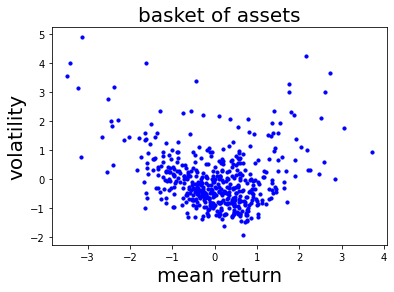

In [11]:
# Plotting the data points
fig, ax = plt.subplots()
ax.scatter(scale_feature_df['mean return'], scale_feature_df['volatility'], c='blue', s=10)
ax.set_title('basket of assets', fontsize=20)
ax.set_xlabel('mean return', fontsize=20)
ax.set_ylabel('volatility', fontsize=20)

In [37]:
from sklearn.cluster import KMeans
data=scale_feature_df.values
model=KMeans(n_clusters=k_clusters) # define a machine learning model using Kmeans algorithm
model.fit(data) # run the algorithm/ fit the model to data
label=model.predict(data) # get the cluster label of each customer
center=model.cluster_centers_

# Scatter plot of mean return vs. volatility each color is a different cluster

Text(0, 0.5, 'volatility')

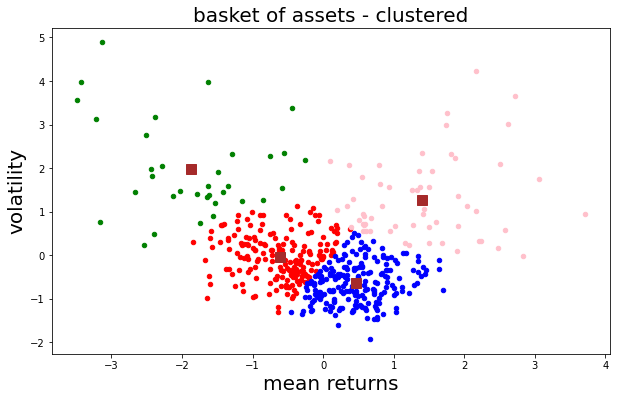

In [38]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(data[label==0, 0], data[label==0, 1], c='red',s=20)
ax.scatter(data[label==1, 0], data[label==1, 1], c='blue', s=20)
ax.scatter(data[label==2, 0], data[label==2, 1], c='green', s=20)
ax.scatter(data[label==3, 0], data[label==3, 1], c='pink', s=20)
ax.plot(center[0,0], center[0,1], c='brown', marker='s', markersize=10)
ax.plot(center[1,0], center[1,1], c='brown', marker='s', markersize=10)
ax.plot(center[2,0], center[2,1], c='brown', marker='s', markersize=10)
ax.plot(center[3,0], center[3,1], c='brown', marker='s', markersize=10)
ax.set_title('basket of assets - clustered', fontsize=20)
ax.set_xlabel('mean returns', fontsize=20)
ax.set_ylabel('volatility', fontsize=20)

## Sort the features dataframe by cluster and then split the features data frame into seperate dataframes each belonging to a single cluster

In [39]:
feature_df['labels']=label
feature_df['labels'] = feature_df['labels'].astype("category")
feature_df.sort_values(by=['labels'])

,mean return,volatility,labels
MMM,-0.183411,0.106008,0
IPG,-0.088910,0.077277,0
IFF,-0.150045,0.087057,0
INTU,-0.047284,0.114658,0
ISRG,-0.134480,0.100004,0
...,...,...,...
PYPL,0.098794,0.158400,3
PAYC,0.094194,0.109586,3
PARA,-0.009457,0.128074,3
OKE,0.063295,0.095843,3


In [15]:
k_list=np.arange(0,k_clusters,1)
k_list
d = {}
for k in k_list:
    d[k] = pd.DataFrame()
    d[k] = feature_df[feature_df['labels'] ==k]

{0:       mean return  volatility labels
 ABBV    -0.057189    0.040779      0
 ACN     -0.061572    0.060347      0
 ATVI    -0.021296    0.023720      0
 ADM      0.060132    0.057543      0
 ADP      0.023879    0.051494      0
 ...           ...         ...    ...
 WMB      0.008214    0.077787      0
 WTW      0.015942    0.055754      0
 GWW      0.023936    0.052480      0
 XEL      0.027682    0.037318      0
 XYL      0.003984    0.102714      0
 
 [215 rows x 3 columns],
 1:       mean return  volatility labels
 MMM     -0.183411    0.106008      1
 AOS     -0.114167    0.081251      1
 ABT     -0.077187    0.054397      1
 ABMD    -0.149033    0.107534      1
 ADBE    -0.121400    0.095832      1
 ...           ...         ...    ...
 WRK     -0.036497    0.089022      1
 WY      -0.091272    0.071149      1
 WHR     -0.137029    0.094779      1
 WYNN    -0.045989    0.120341      1
 YUM     -0.129340    0.048028      1
 
 [189 rows x 3 columns],
 2:       mean return  volat

# As an example:
## 1. Take one of the clusters as the basket of assets
## 2. Calculate the Hurst exponent for every possible pair within said cluster 
## 3. Pick the pairs with lowest Hurst exponent and run it through the original algo to get the returns (backtest)
* see part 3 for details

### Let's use the cluster with the highests vol and lowest returns over 30 days and see if the pairs trading with copula (see part 1) algo can beat a long only strategy

### Sort the cluster centers based on volatility and pick the cluster with highest vol

In [ ]:
d_scale = {}
for k in k_list:
    d_scale[k] = pd.DataFrame()
    d_scale[k] = scale_feature_df[feature_df['labels'] ==k]

mean_list=[]
vol_list=[]
for i in k_list:
    mean_list.append(d_scale[i]['mean return'].mean())
    vol_list.append(d_scale[i]['volatility'].mean())
center_list=list(zip(mean_list,vol_list,k_list))

def sort_tuple(tup):
    tup.sort(key = lambda x: x[1])
    return tup
center_list=sort_tuple(center_list)

## Sort the assets in each cluster into a dictionary of lists (each lists corresponds to a cluster)
### In this case, we are just choosing one cluster to minimise computation

In [21]:
asset_dict = {}
for a in k_list:
    asset_dict[a] = d[a].index.tolist()
asset_dict[center_list[-1][2]]

['AAP',
 'ALGN',
 'AMD',
 'AMAT',
 'APTV',
 'BALL',
 'BBY',
 'CZR',
 'CTLT',
 'CRL',
 'DLTR',
 'DXC',
 'FTNT',
 'GNRC',
 'HPQ',
 'ILMN',
 'LRCX',
 'LNC',
 'MTCH',
 'MU',
 'MRNA',
 'TAP',
 'NVDA',
 'PENN',
 'PKI',
 'PVH',
 'QRVO',
 'CRM',
 'STX',
 'SEDG',
 'TER',
 'WBD',
 'WAT',
 'WDC']

# Run assets in cluster through algo (see part 3) to get returns via Hurst

In [ ]:
h=Hurst()
hurst_returns=h.get_hurst_return(asset_dict[center_list[-1][2]] ,start_data,end_data,start_trade,end_trade,int(len(asset_dict[center_list[-1][2]])/2))
hurst_returns

# Metrics

In [29]:
index_price = yf.download(index_comp, start=start_trade, end=end_trade)
index_price = index_price['Adj Close']
index_ret = index_price.pct_change().dropna()

metrics= pd.DataFrame(index=['Algo-KMeans'], columns=['Total return', 'APR', 'Sharpe', 'Max Drawdown', 'Max Drawdown Duration'])
metrics.loc['Algo-KMeans'] =h.metrics_calc(np.nancumprod(hurst_returns + 1))

metrics.loc['Index']=h.metrics_calc(np.nancumprod(index_ret + 1))
metrics


[*********************100%***********************]  1 of 1 completed


,Total return,APR,Sharpe,Max Drawdown,Max Drawdown Duration
Algo-KMeans,0.020057,0.255417,4.563792,-0.002939,1.0
Index,-0.031564,-0.307454,-1.855592,-0.080335,11.0


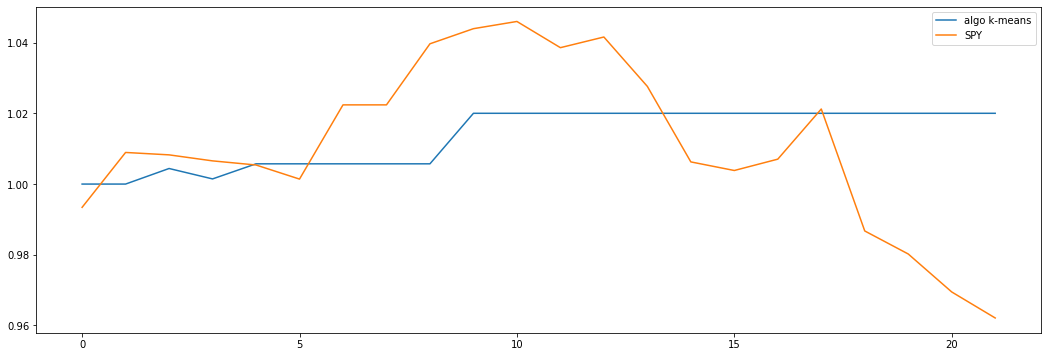

In [28]:
plt.figure(figsize=(18,6))
plt.plot(np.nancumprod(hurst_returns + 1), label='algo k-means')
plt.plot(np.nancumprod(index_ret + 1), label=index_comp)
plt.legend()

### Clearly it did better than randomly picking pairs, but would be interesting to backtest algo with all possible clusters